<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import seaborn.apionly as sns
import pandas as pd
import pcmdpy as ppy
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
import pcmdpy as ppy
%matplotlib inline

GPU acceleration enabled


In [2]:
sns.set_context('poster')

In [3]:
files = ['../data/h_m51_i_s05_drz_sci.fits', '../data/h_m51_v_s05_drz_sci.fits', '../data/h_m51_b_s05_drz_sci.fits']
filts = ppy.instrument.m51_filters
m51 = ppy.utils.DataSet(files, filts)

In [4]:
f1 = m51.filters

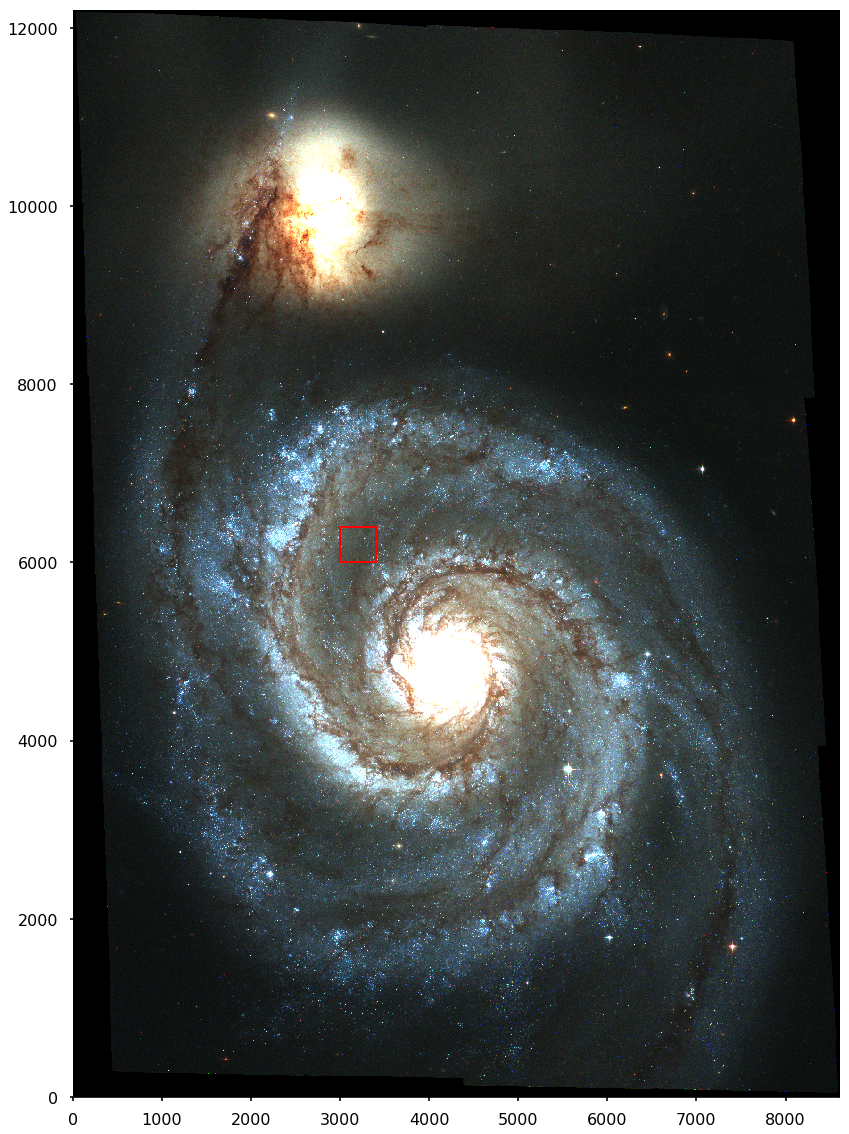

In [36]:
# fig, ax = plt.subplots(figsize=(15, 20))
# ims, extent = m51.get_image(downsample=10)
# _ = ppy.utils.plot_rgb_image(ims, extent=extent, ax=ax)
# r = ax.add_patch(mpl.patches.Rectangle((3000, 6000), 400, 400, color='r', lw=2, fill=False))

In [5]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    GPU_AVAIL = True
except:
    GPU_AVAIL = False

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [6]:
try:
    iso_model
except NameError:
    iso_model = ppy.isochrones.Isochrone_Model(f1)
driv = ppy.driver.Driver(iso_model, gpu=GPU_AVAIL)

In [7]:
X, Y = np.meshgrid(np.arange(m51.im_shape[1]), np.arange(m51.im_shape[0]))

In [8]:
bools = (3000 <= X) & (X < 3400) & (6000 <= Y) & (Y < 6400) 

In [34]:
# bools = (4000 <= X) & (X < 4400) & (4600 <= Y) & (Y < 5000) 

CPU times: user 1.02 s, sys: 15.2 ms, total: 1.03 s
Wall time: 1.05 s


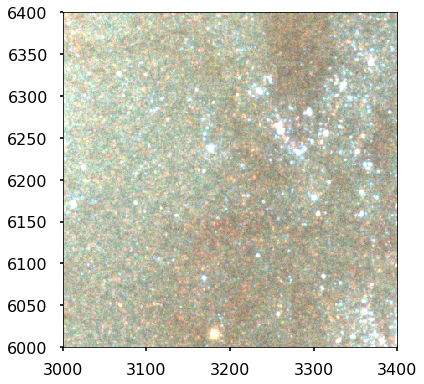

In [35]:
# %%time
# fig, ax = plt.subplots(figsize=(6, 12))
# ims_data, extent = m51.get_image(bools, downsample=1)
# ax = ppy.utils.plot_rgb_image(ims_data, extent=extent, ax=ax)

In [9]:
%%time
pcmd_data = m51.get_pcmd(bools)

CPU times: user 252 ms, sys: 141 ms, total: 393 ms
Wall time: 1.32 s


In [10]:
dmod_m51 = 25. + 5.*np.log10(8.58)
ssp = ppy.galaxy.DefaultSSP
ssp.distance_model.dmod = dmod_m51
ssp.set_params(np.array([-0., -.5, 3., 10.]))
gal = ppy.galaxy.LogNormTau
gal.age_model = ppy.agemodels.TauModel(iso_step=-1.)
gal.distance_model.dmod = dmod_m51
gal.set_params(np.array([0., -.1, 0.5, 5.0, 100.]))

In [11]:
%%time
pcmd_test, ims_test = driv.simulate(gal, 400, downsample=5, psf=True)

CPU times: user 432 ms, sys: 400 ms, total: 832 ms
Wall time: 1.82 s


In [31]:
bins = [np.linspace(-1, 3,100), np.linspace(20., 30., 100)]
# bins=100

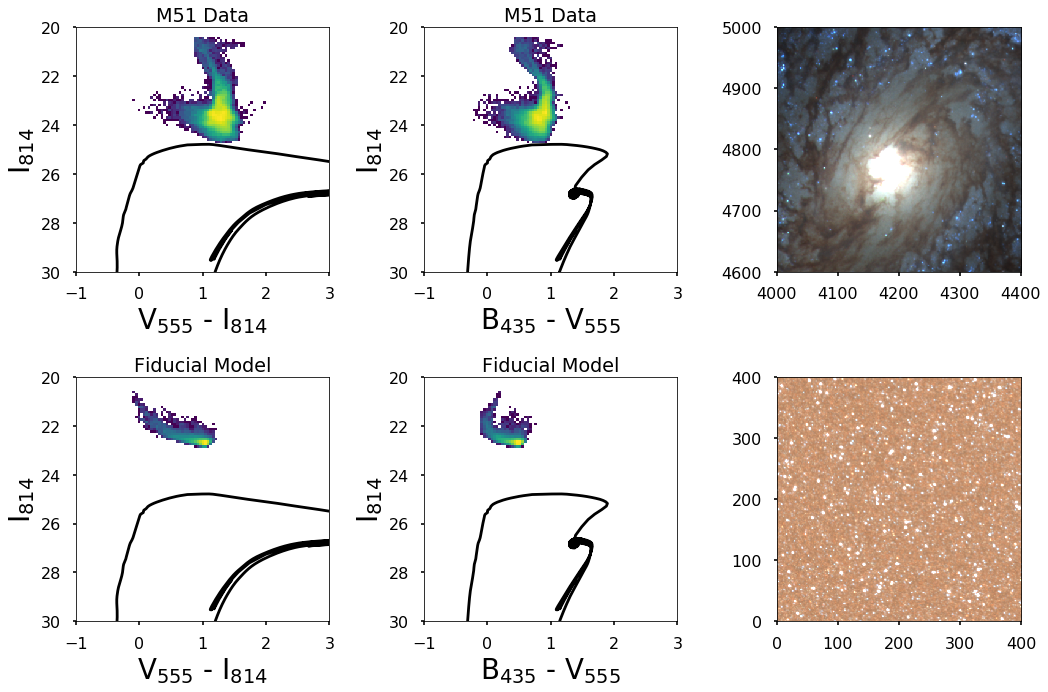

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_data[1], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_data[2], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_test[1], pcmd_test[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_test[2], pcmd_test[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('M51 Data')
for a in axes[1,:2]:
    a.set_title('Fiducial Model')
# ppy.utils.plot_rgb_image(ims_data, extent=extent, ax=axes[0,2])
# ppy.utils.plot_rgb_image(ims_test, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_test.pdf')

In [27]:
# base_info = 'Vega Mags\nDisk Gap region extracted from square X=[3000,3400), Y=[6000, 6400) from M51 image'
# np.savetxt('../data/m51_gap_I-VI-BV.dat', pcmd_data.T, fmt='%.6f', header='Imag Vmag-Imag Bmag-Vmag\nF814W F555W-F814W F435W-F555W\n'+base_info)
# np.savetxt('../data/m51_gap_I-BV.dat', pcmd_data[::2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F435W-F555W\n'+base_info)
# np.savetxt('../data/m51_gap_I-VI.dat', pcmd_data[:2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F555W-F814W\n'+base_info)

In [17]:
base_info = 'Vega Mags\nDisk Gap region extracted from square X=[3000,3400), Y=[6000, 6400) from M51 image'
np.savetxt('../data/m51_bulge_I-VI-BV.dat', pcmd_data.T, fmt='%.6f', header='Imag Vmag-Imag Bmag-Vmag\nF814W F555W-F814W F435W-F555W\n'+base_info)
np.savetxt('../data/m51_bulge_I-BV.dat', pcmd_data[::2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F435W-F555W\n'+base_info)
np.savetxt('../data/m51_bulge_I-VI.dat', pcmd_data[:2].T, fmt='%.6f', header='Imag Bmag-Vmag\nF814W F555W-F814W\n'+base_info)

In [16]:
pcmd = np.loadtxt('../data/m51_gap_I-VI-BV.dat', unpack=True)

In [6]:
results = {}

In [7]:
results['IVB'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IVB.csv', run_name='M51 Gap - I,V,B bands')
results['IVB_ll0'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IVB_ll0.csv', run_name='M51 Gap - I,V,B bands - LM=0')
results['IV'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IV.csv', run_name='M51 Gap - I,V bands')
results['IB'] = ppy.utils.ResultsPlotter('results/m51_gap_tau_IB.csv', run_name='M51 Gap - I,B bands')

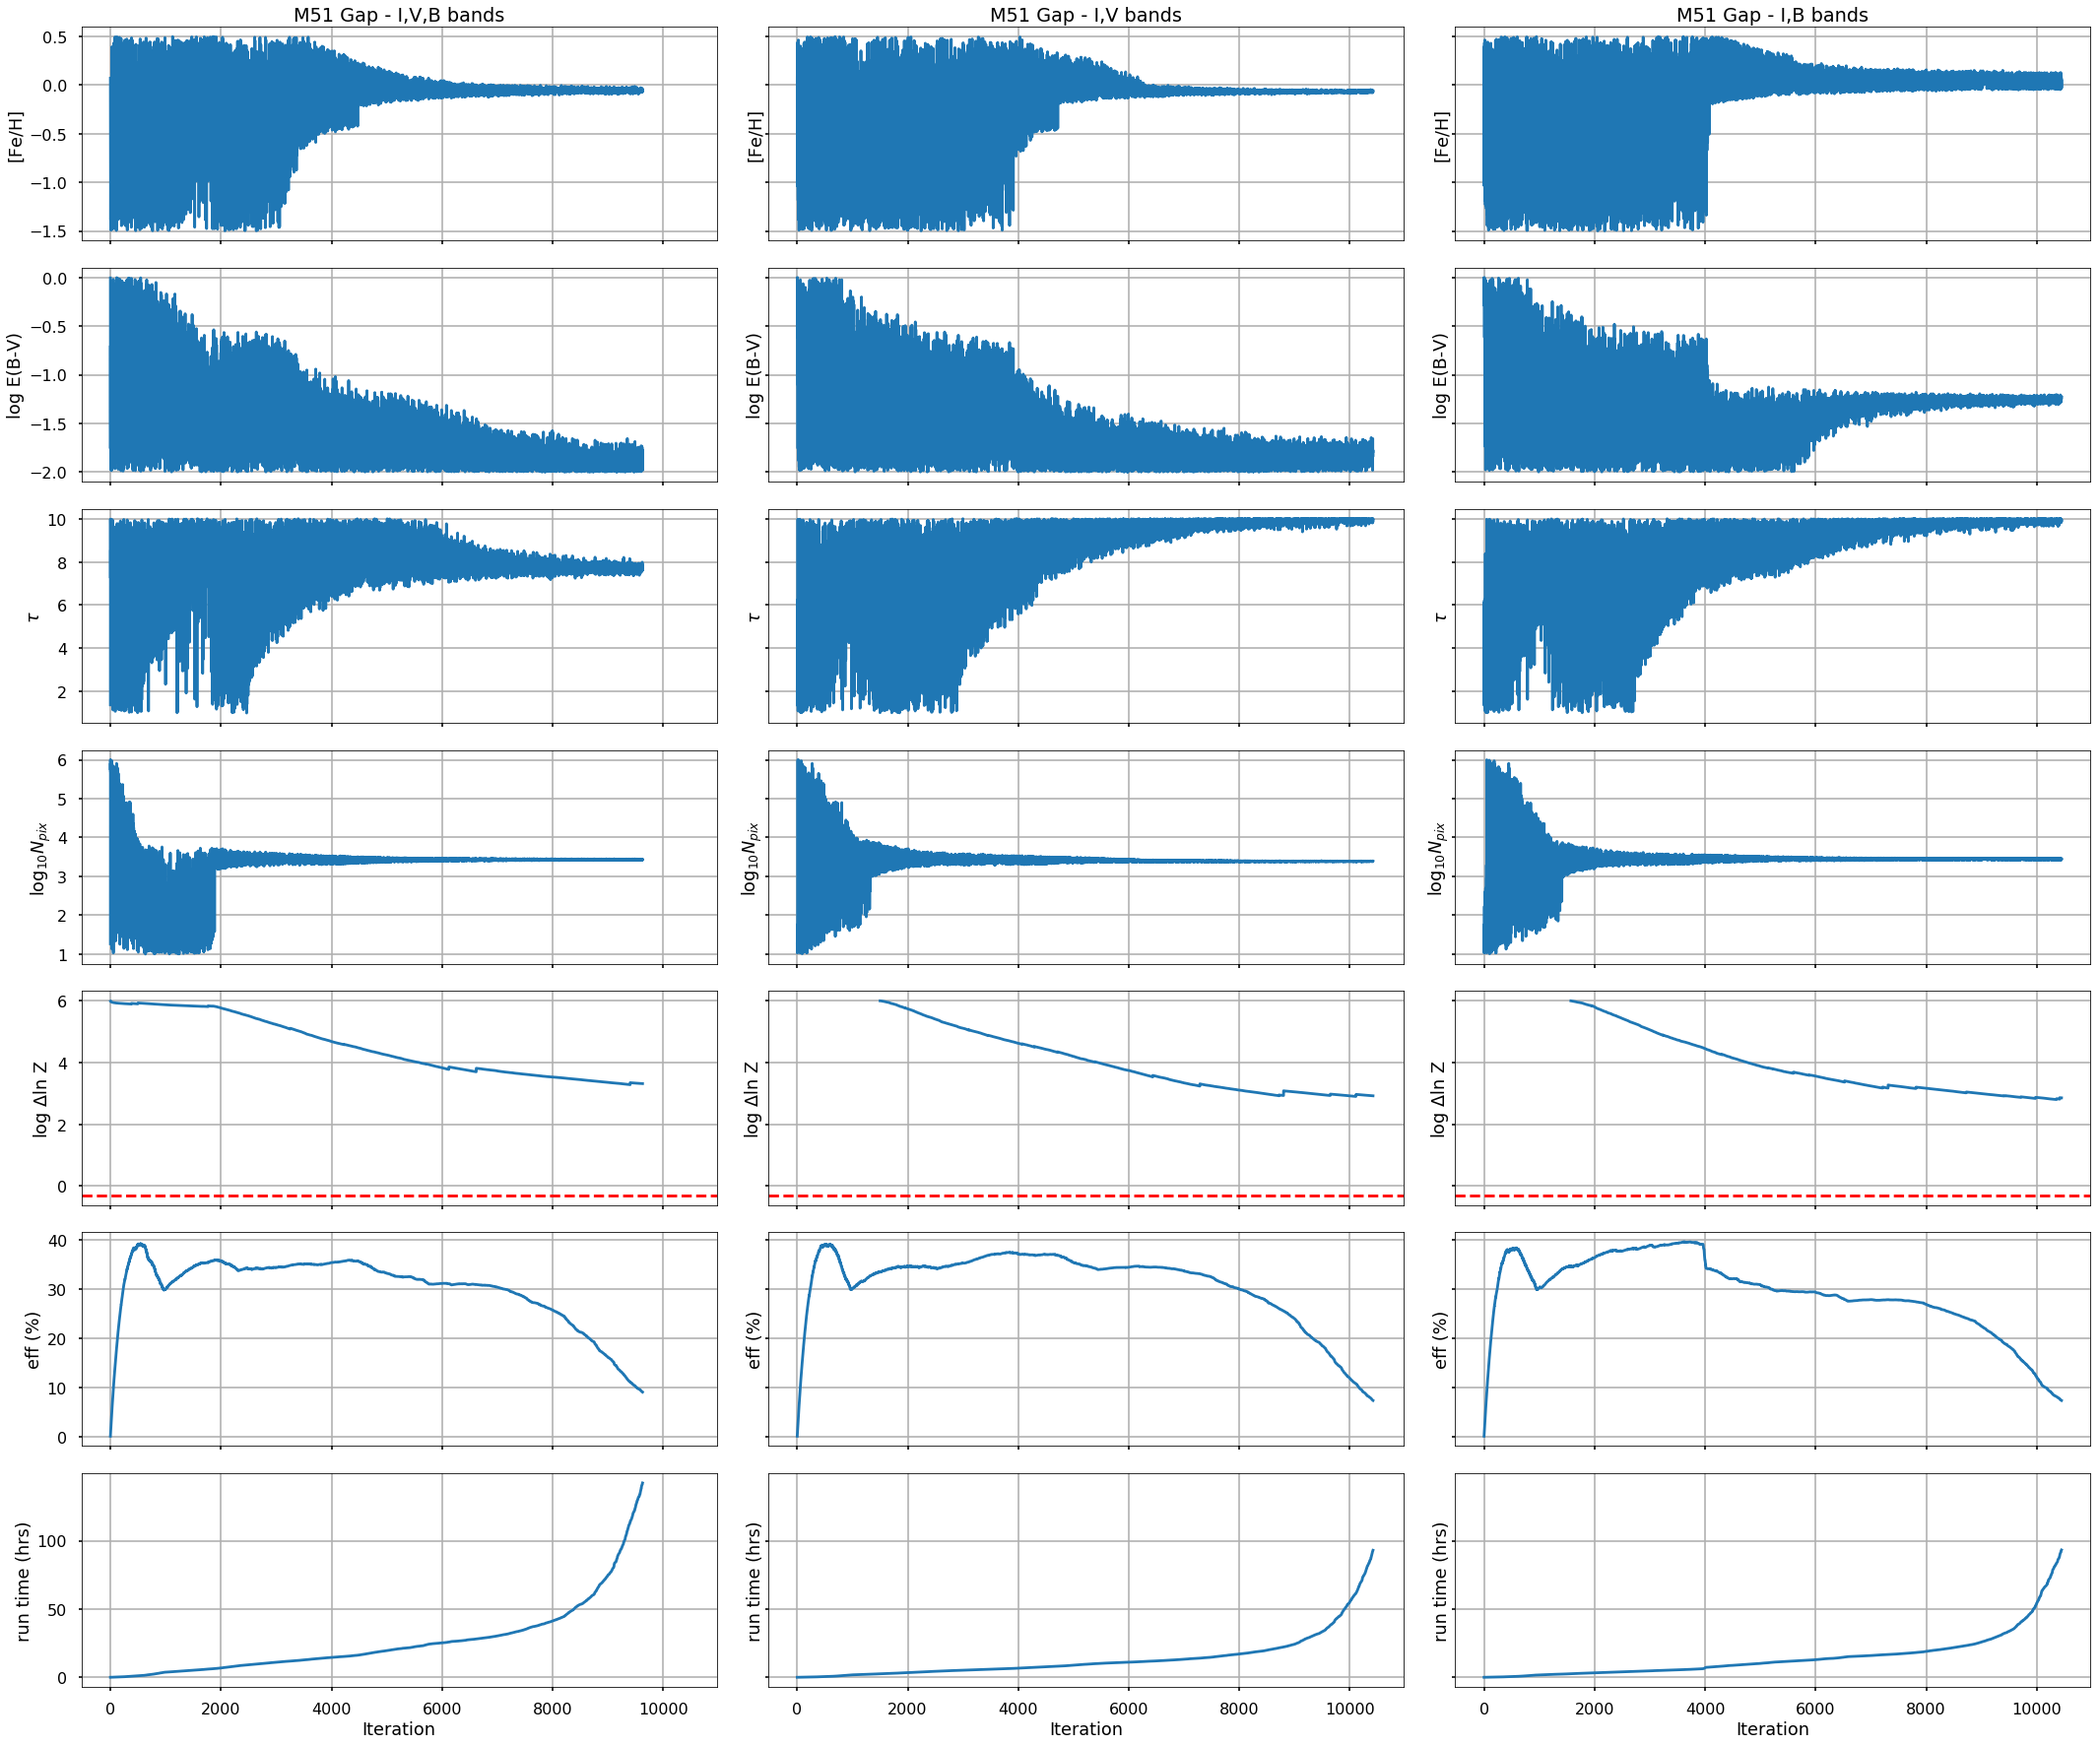

In [8]:
#### sns.set_context('poster')
fix, axes = plt.subplots(ncols=3, nrows=7, figsize=(30, 25), sharex=True, sharey='row')
results['IVB'].plot_chains(axes=axes[:,0])
results['IV'].plot_chains(axes=axes[:,1])
results['IB'].plot_chains(axes=axes[:,2])
for ax in axes.flatten():
    ax.grid(True)
plt.tight_layout()

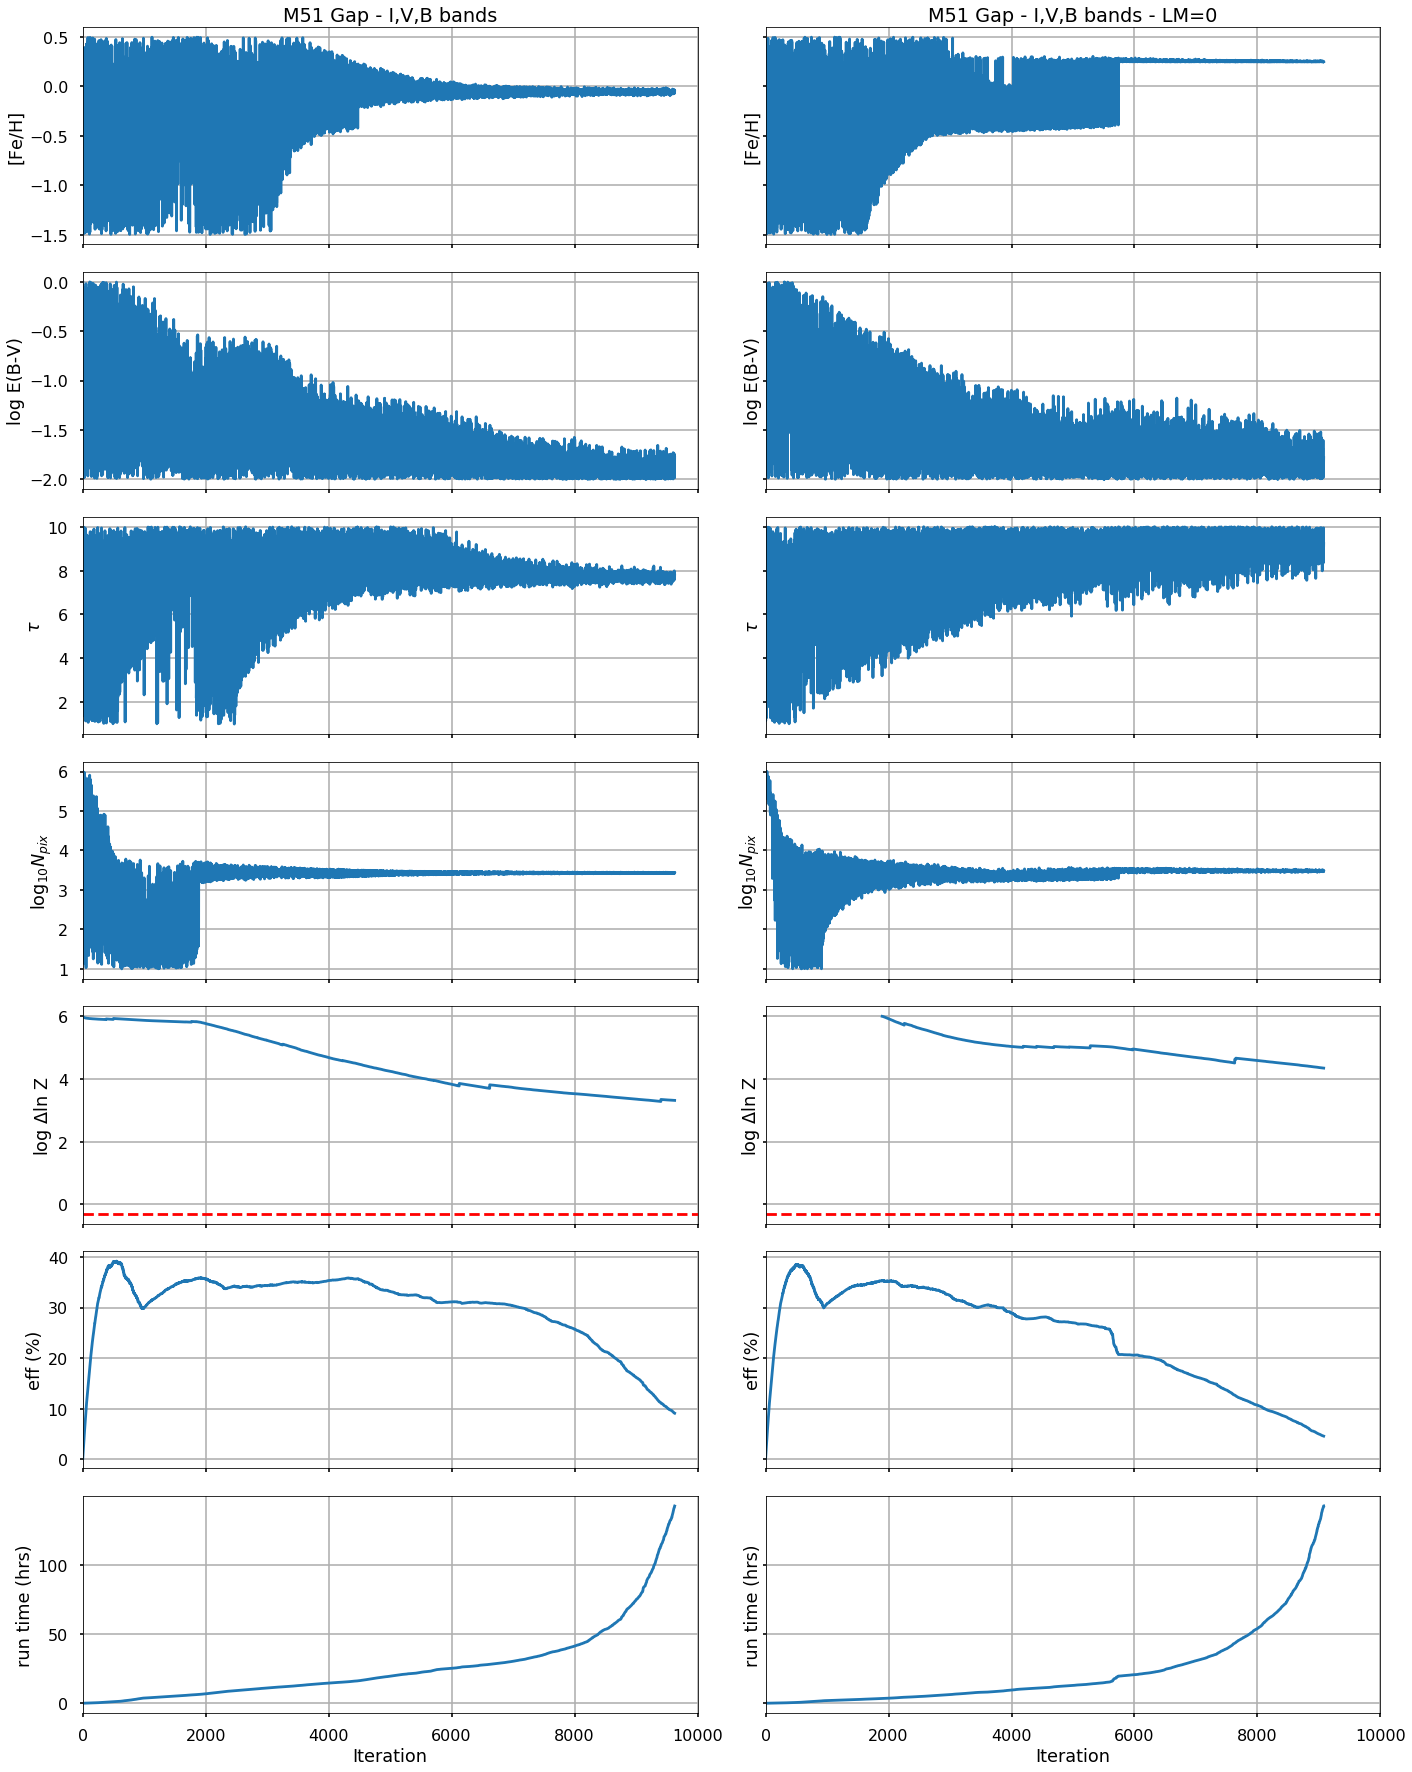

In [9]:
#### sns.set_context('poster')
fix, axes = plt.subplots(ncols=2, nrows=7, figsize=(20, 25), sharex=True, sharey='row')
results['IVB'].plot_chains(axes=axes[:,0])
results['IVB_ll0'].plot_chains(axes=axes[:,1])
axes[0,0].set_xlim([0, 10000])
for ax in axes.flatten():
    ax.grid(True)
plt.tight_layout()

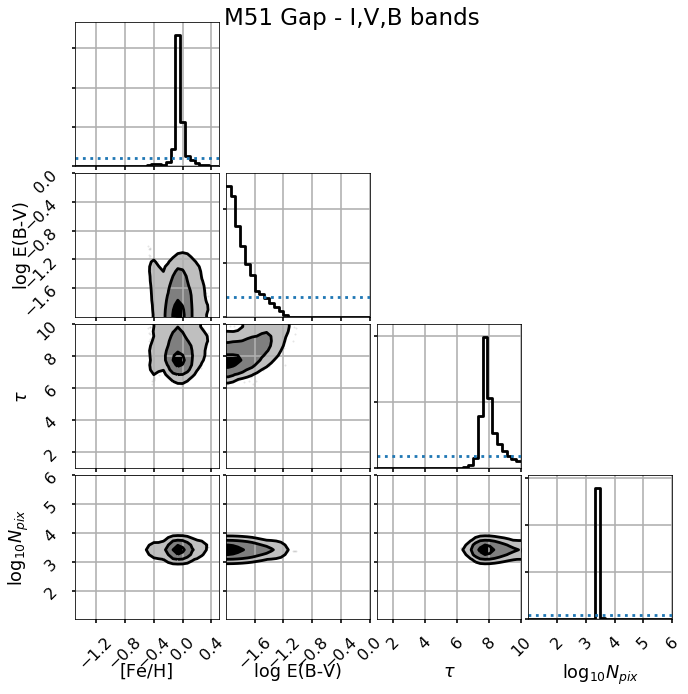

In [21]:
fig, axes = results['IVB'].plot_corner(weight=False, burn=4000, bins=30);
for ax in axes.flatten():
    ax.grid(True)

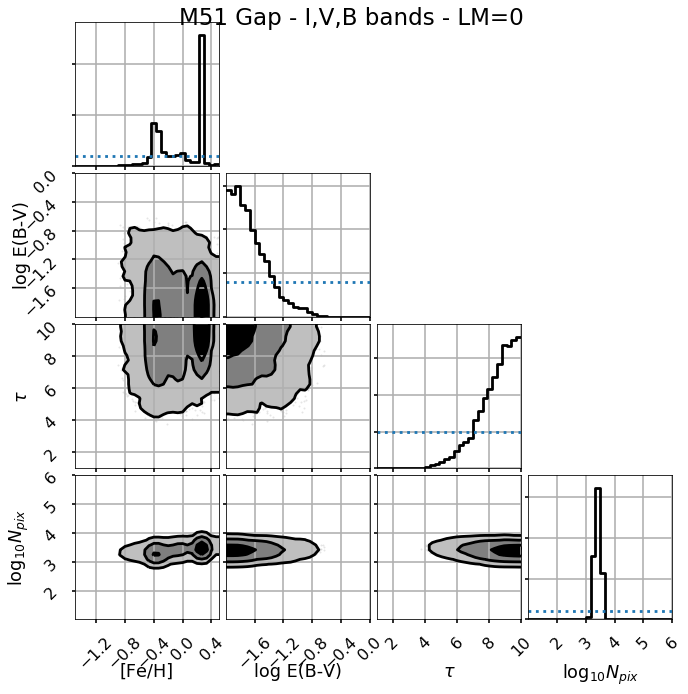

In [22]:
fig, axes = results['IVB_ll0'].plot_corner(weight=False, burn=2000, bins=30);
for ax in axes.flatten():
    ax.grid(True)

In [23]:
%%time
gal = ppy.galaxy.DefaultTau.get_model(np.array([-0.1, -2., 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_fit, ims_fit = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=False)

CPU times: user 48.9 s, sys: 3.74 s, total: 52.7 s
Wall time: 53 s


In [24]:
%%time
gal = ppy.galaxy.LogNormTau.get_model(np.array([-0.1, -.3, 0.5, 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_dust, ims_dust = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=False)

CPU times: user 57.1 s, sys: 3.75 s, total: 1min
Wall time: 1min 1s


In [25]:
%%time
gal = ppy.galaxy.DefaultTau.get_model(np.array([-0.1, -2., 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_shot, ims_shot = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=True)

CPU times: user 48.6 s, sys: 3.68 s, total: 52.3 s
Wall time: 52.5 s


In [26]:
%%time
gal = ppy.galaxy.MDFTau.get_model(np.array([-0.1, 0.5, -2., 3.4, 7.5, dmod_m51]), iso_step=-1.)
pcmd_mdf, ims_mdf = driv.simulate(gal, 400, downsample=5, psf=True, shot_noise=False)

CPU times: user 4min 40s, sys: 50 s, total: 5min 30s
Wall time: 5min 44s


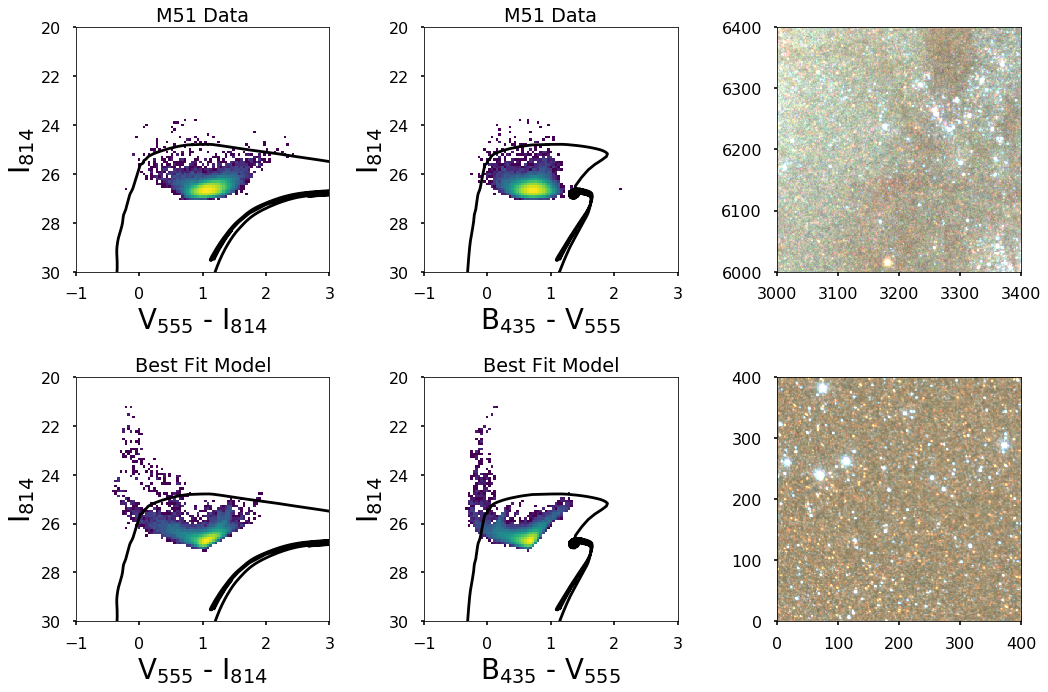

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_data[1], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_data[2], pcmd_data[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('M51 Data')
for a in axes[1,:2]:
    a.set_title('Best Fit Model')
ppy.utils.plot_rgb_image(ims_data, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_fit, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')

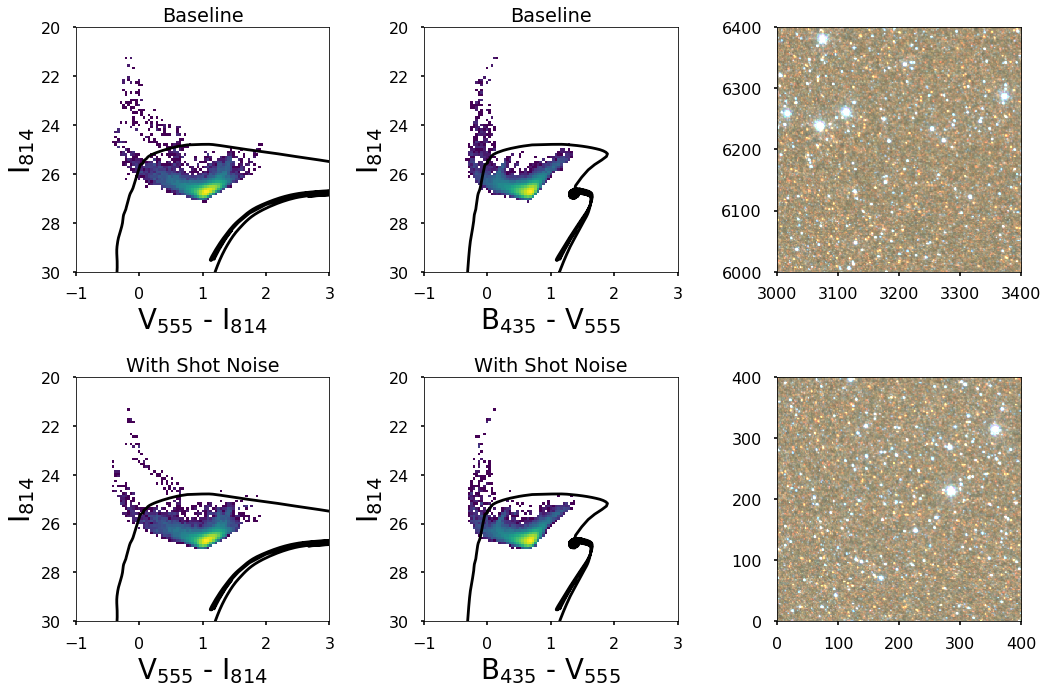

In [28]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_shot[1], pcmd_shot[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_shot[2], pcmd_shot[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('Baseline')
for a in axes[1,:2]:
    a.set_title('With Shot Noise')
ppy.utils.plot_rgb_image(ims_fit, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_shot, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')

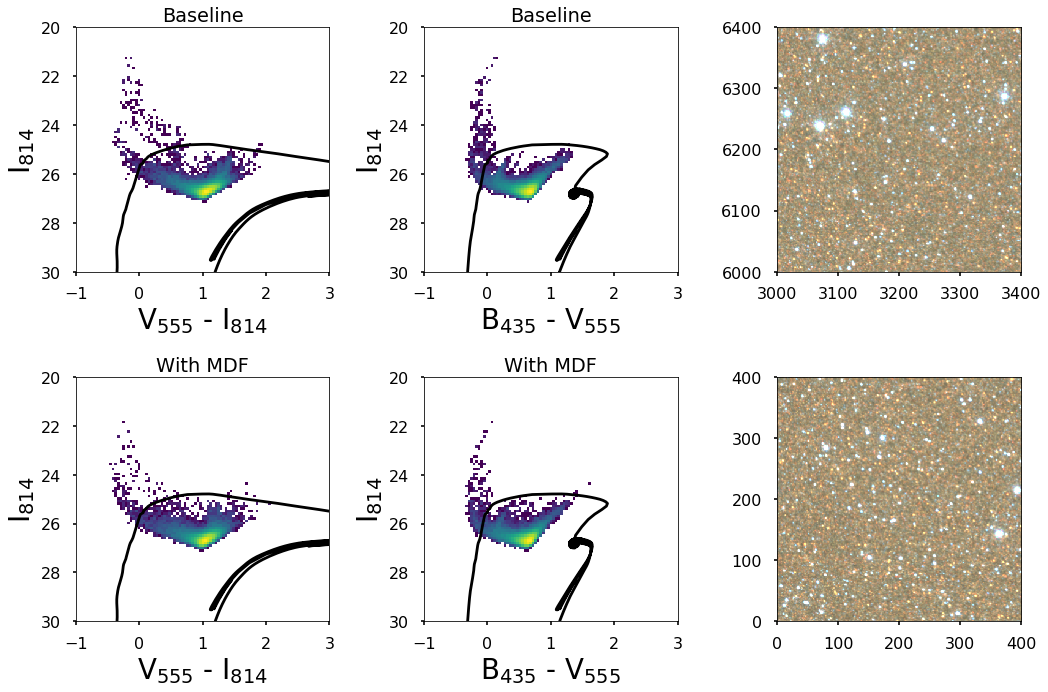

In [29]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_mdf[1], pcmd_mdf[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_mdf[2], pcmd_mdf[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('Baseline')
for a in axes[1,:2]:
    a.set_title('With MDF')
ppy.utils.plot_rgb_image(ims_fit, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_mdf, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')

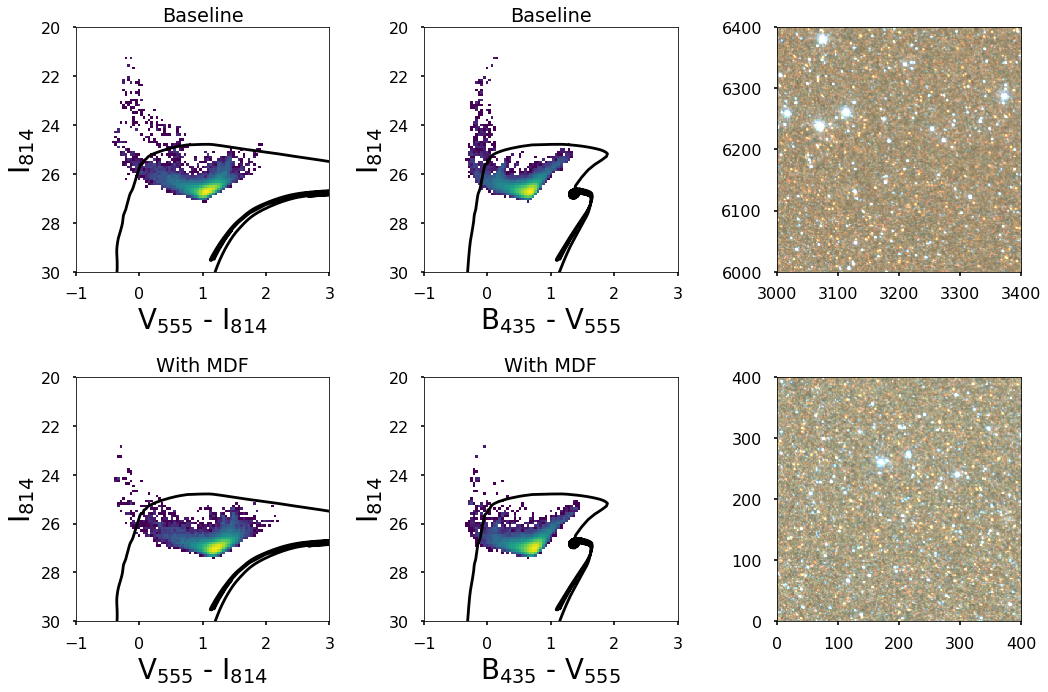

In [30]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
axes[0,0].hist2d(pcmd_fit[1], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[0,1].hist2d(pcmd_fit[2], pcmd_fit[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,0].hist2d(pcmd_dust[1], pcmd_dust[0], bins=bins, norm=mpl.colors.LogNorm())
axes[1,1].hist2d(pcmd_dust[2], pcmd_dust[0], bins=bins, norm=mpl.colors.LogNorm())
for a in axes[0,:2]:
    a.set_title('Baseline')
for a in axes[1,:2]:
    a.set_title('With MDF')
ppy.utils.plot_rgb_image(ims_fit, extent=extent, ax=axes[0,2])
ppy.utils.plot_rgb_image(ims_dust, ax=axes[1,2])
iso_model.plot_isochrone(ssp, axes=axes[0,:2], system='vega')
iso_model.plot_isochrone(ssp, axes=axes[1,:2], system='vega')
plt.tight_layout()
# plt.savefig('figures/m51_bestfit.pdf')